<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/a10/assignment/assignment-10/Anjali_Ojha_HW_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GitHub Link -

# BERT for QnA:

# 1. Load the SQUAD 2.0 (https://pytorch.org/text/stable/datasets.html#torchtext.datasets.SQuAD2) dataset from pytorch dataset library. take minimum 20 QnA pairs.




In [ ]:
! pip install datasets
! pip install portalocker
! pip install transformers datasets torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-

In [ ]:
!mkdir data
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O data/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O data/dev-v2.0.json

--2024-04-24 20:36:23--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘data/train-v2.0.json’

data/train-v2.0.jso 100%[===================>]  40.17M   242MB/s    in 0.2s    

2024-04-24 20:36:23 (242 MB/s) - ‘data/train-v2.0.json’ saved [42123633/42123633]

--2024-04-24 20:36:23--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘data/dev-v2.0.json’

data/d

In [ ]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

In [ ]:
import json

def load_data(json_path):
    """ Load data from Json file and extract differnet informations. """
    with open(json_path, 'r') as reader:
        data = json.load(reader)

    contexts = []
    questions = []
    answers = []

    for group in data['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers


train_texts, train_queries, train_answers = load_data('data/train-v2.0.json')
print("Train Questions = ", train_queries[:1])
print(len(train_texts), len(train_answers))

test_texts, test_queries, test_answers = load_data('data/dev-v2.0.json')
print("Test Questions = ", test_queries[:1])
print(len(test_texts), len(test_answers))


Train Questions =  ['When did Beyonce start becoming popular?']
86821 86821
Test Questions =  ['In what country is Normandy located?']
20302 20302


In [ ]:
# Taking sub-sample of the data
num_samples = 500

train_texts = train_texts[:num_samples]
train_queries = train_queries[:num_samples]
train_answers = train_answers[:num_samples]

test_texts = test_texts[:num_samples]
test_queries = test_queries[:num_samples]
test_answers = test_answers[:num_samples]

# 2. Display a few raw QnA data samples.


In [ ]:
# Printing 5 differnet samples of question and answers
print("Context = ", train_texts[0])
for i in range(5):
    print(f"\nsample = {i+1}, \n\t Ques = {train_queries[i]}, \n\t Ans  = {train_answers[i]['text']}")

Context =  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".

sample = 1, 
	 Ques = When did Beyonce start becoming popular?, 
	 Ans  = in the late 1990s

sample = 2, 
	 Ques = What areas did Beyonce compete in when she was growing up?, 
	 Ans  = singing and dancing

sample = 3, 
	 Ques = When did Beyonce leave Destiny's Child and become a solo singer?,

# 3. Preprocess/Clean dataset as per BERT format.

In [ ]:
def add_start_end(answers, texts):
    """ This method add the start and end index for the answer in the context data """
    for answer, text in zip(answers, texts):
        real_answer = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(real_answer)

        if text[start_idx:end_idx] == real_answer:
            answer['answer_end'] = end_idx
        elif text[start_idx-1:end_idx-1] == real_answer:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1
        elif text[start_idx-2:end_idx-2] == real_answer:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2
    return answers, texts


train_answers, train_texts = add_start_end(train_answers, train_texts)
test_answers, test_texts = add_start_end(test_answers, test_texts)

train_answers[0]

{'text': 'in the late 1990s', 'answer_start': 269, 'answer_end': 286}

In [ ]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
test_encodings  = tokenizer(test_texts, test_queries, truncation=True, padding=True)


In [ ]:
def add_token_positions(encodings, answers):
    start_positions, end_positions = [], []
    count = 0

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

        if start_positions[-1] is None: # if start position is None, then discard data
            start_positions[-1] = tokenizer.model_max_length

        if end_positions[-1] is None:   # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
            end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)

        if end_positions[-1] is None:  # if end position is  None, then discard data
            count += 1
            end_positions[-1] = tokenizer.model_max_length

    print(count)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(test_encodings, test_answers)

0
0


In [ ]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [ ]:
train_dataset = SquadDataset(train_encodings)
test_dataset  = SquadDataset(test_encodings)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


# 4. Train the BERT QnA model. Evaluate the model.


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)
optim = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
start_time = time.time()

train_losses, test_losses = [], []
epochs = 10

print("Training Started ..... \n")

for epoch in range(epochs):
    epoch_time = time.time()
    model.train()
    loss_of_epoch = 0

    for idx, batch in enumerate(train_loader):

        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()              # back propogation
        optim.step()                 # weights update
        loss_of_epoch += loss.item() # adding losses

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    model.eval()
    loss_of_epoch = 0

    for idx, batch in enumerate(test_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            loss_of_epoch += loss.item()

    loss_of_epoch /= len(test_loader)
    test_losses.append(loss_of_epoch)
    print(f"Epoch = {epoch}, training loss = {train_losses[-1]:.7f}, test loss = {test_losses[-1]}")


print("\nTotal training and evaluation time: ", (time.time() - start_time))

Training Started ..... 

Epoch = 0, training loss = 4.5494220, test loss = 3.9954635680667936
Epoch = 1, training loss = 3.3779226, test loss = 3.6967673036787243
Epoch = 2, training loss = 2.8105820, test loss = 3.5914867378416515
Epoch = 3, training loss = 2.2116908, test loss = 3.3226727758135115
Epoch = 4, training loss = 1.5189209, test loss = 3.1685539578634594
Epoch = 5, training loss = 1.0978627, test loss = 3.067789904654972
Epoch = 6, training loss = 0.8292233, test loss = 2.8540192577573986
Epoch = 7, training loss = 0.6776644, test loss = 2.8058945054099675
Epoch = 8, training loss = 0.4109644, test loss = 2.8598757774110823
Epoch = 9, training loss = 0.2829685, test loss = 2.8447201800724815

Total training and evaluation time:  572.1129274368286


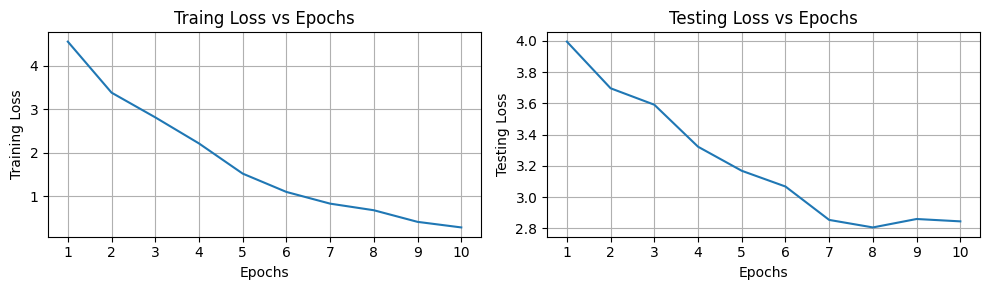

In [ ]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, accuracies):
    """
        Plot the traning metrics
    """

    fig, axs = plt.subplots(1, 2, figsize=(10, 3))

    axs[0].plot(list(range(1, len(losses)+1)), losses)
    axs[0].set_title('Traing Loss vs Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Training Loss')
    axs[0].set_xticks(list(range(1, len(losses)+1)))
    axs[0].grid(True)

    axs[1].plot(list(range(1, len(losses)+1)), accuracies)
    axs[1].set_title('Testing Loss vs Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Testing Loss')
    axs[1].set_xticks(list(range(1, len(losses)+1)))
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_metrics(train_losses, test_losses)

# 5. Perform an Inference and show the predicted vs ground truth answers.

In [ ]:
def give_answer(model, question, context, truth):
    """ Given a input question and context, it will return the answers """
    model.eval()
    inputs = tokenizer(question, context, truncation="only_second", max_length=512,
                       padding="max_length", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits) + 1
    answer_tokens = inputs["input_ids"][0][start_index:end_index]
    answer = tokenizer.decode(answer_tokens)
    print("\nQuestion = ", question)
    print(" Truth       = ", truth)
    print(" Prediction  = ", answer)


In [ ]:
context = """India has the second-largest population in the world. India is also knowns as Bharat, Hindustan and sometimes Aryavart.
It is surrounded by oceans from three sides which are Bay Of Bengal in the east, the Arabian Sea in the west and Indian oceans in the south.
Tiger is the national animal of India."""

give_answer(model, "What is the national animal of India?" , context, '')
give_answer(model, "India is also know as?" , context, 'Bharat, Hindustan and sometimes Aryavart')
give_answer(model, "What is the national flower of India?" , context, 'lotus')



Question =  What is the national animal of India?
 Truth       =  
 Prediction  =  tiger

Question =  India is also know as?
 Truth       =  Bharat, Hindustan and sometimes Aryavart
 Prediction  =  hindustan and sometimes aryavart. it is surrounded by oceans

Question =  What is the national flower of India?
 Truth       =  lotus
 Prediction  =  tiger


# Observations -
*  The model can answer very basic questions.
*  Model misses some very visible patterns, which shows the model is undertrain and need a lot more training.
*  Sometimes it gives also the extra information which is not required.
*  Model can not give answers for the facts which it is not aware of like national flower as 'lotus'.
*  The training and validation plots shows sign of learning but not way close to the full convergence.
*  Model can also benefit from the hyper-parameter tunning.